In [1]:
%gui qt5

In [158]:
import numpy as np
import pandas as pd

import starfish
from starfish.types import Axes

## Obtain a single Field of View

In [3]:
exp = starfish.Experiment.from_json('https://d2nhj9g34unfro.cloudfront.net/nico_pierson/multiplexed/experiment.json')
fov = exp.fov()

## Create a spot finding workflow using a per-round approach

In [229]:
# call spots per round
per_round_spot_results = {}
for r in range(4):
    image = fov.get_image("primary", rounds=[r], x=slice(1700, 2048), y=slice(1700, 2048))

    wth = starfish.image.Filter.WhiteTophat(masking_radius=3)
    background_corrected = wth.run(image, in_place=False)

    mh = starfish.image.Filter.MatchHistograms(group_by={Axes.CH, Axes.ROUND})
    scaled = mh.run(background_corrected)

    lsbd = starfish.spots.DetectSpots.LocalSearchBlobDetector(
        min_sigma=0.4,
        max_sigma=2.5,
        num_sigma=7,
        threshold=0.02,
#         is_volume=True,
        anchor_round=0,
        search_radius=2.45
    )
    per_tile_spot_results = lsbd._find_spots(
        scaled,
        verbose=False,
        n_processes=None,
    )
    per_round_spot_results[r] = lsbd._merge_spots_by_round(per_tile_spot_results)
    

# unlist dfs
per_round_spot_results_unnested = {k: v[k] for k, v in per_round_spot_results.items()}

# results dicts
anchor_round = 0

dist, ind = starfish.spots.DetectSpots.LocalSearchBlobDetector._match_spots(
    per_round_spot_results_unnested,
    search_radius=lsbd.search_radius, anchor_round=anchor_round
)

intensity_table = starfish.spots.DetectSpots.LocalSearchBlobDetector._build_intensity_table(
    per_round_spot_results_unnested, dist, ind,
    rounds=[0, 1, 2, 3],
    channels=scaled.xarray[Axes.CH.value].values,
    search_radius=lsbd.search_radius,
    anchor_round=anchor_round
)

decoder = starfish.spots.Decode.PerRoundMaxChannel(exp.codebook)
decoded = decoder.run(intensity_tables[0].fillna(0))

names, counts = np.unique(decoded.target.values, return_counts=True)
gene_counts = pd.Series(counts, names)

decoded = decoded[decoded.target != "nan"]

100%|██████████| 108/108 [00:04<00:00, 21.65it/s]


### Look at a few results

In [175]:
camk2a = decoded[decoded.target == "Camk2a"]
Rbfox3 = decoded[decoded.target == "Rbfox3"]

In [172]:
maxproj = scaled.max_proj(Axes.CH, Axes.ZPLANE)

100%|██████████| 1/1 [00:00<00:00, 180.83it/s]


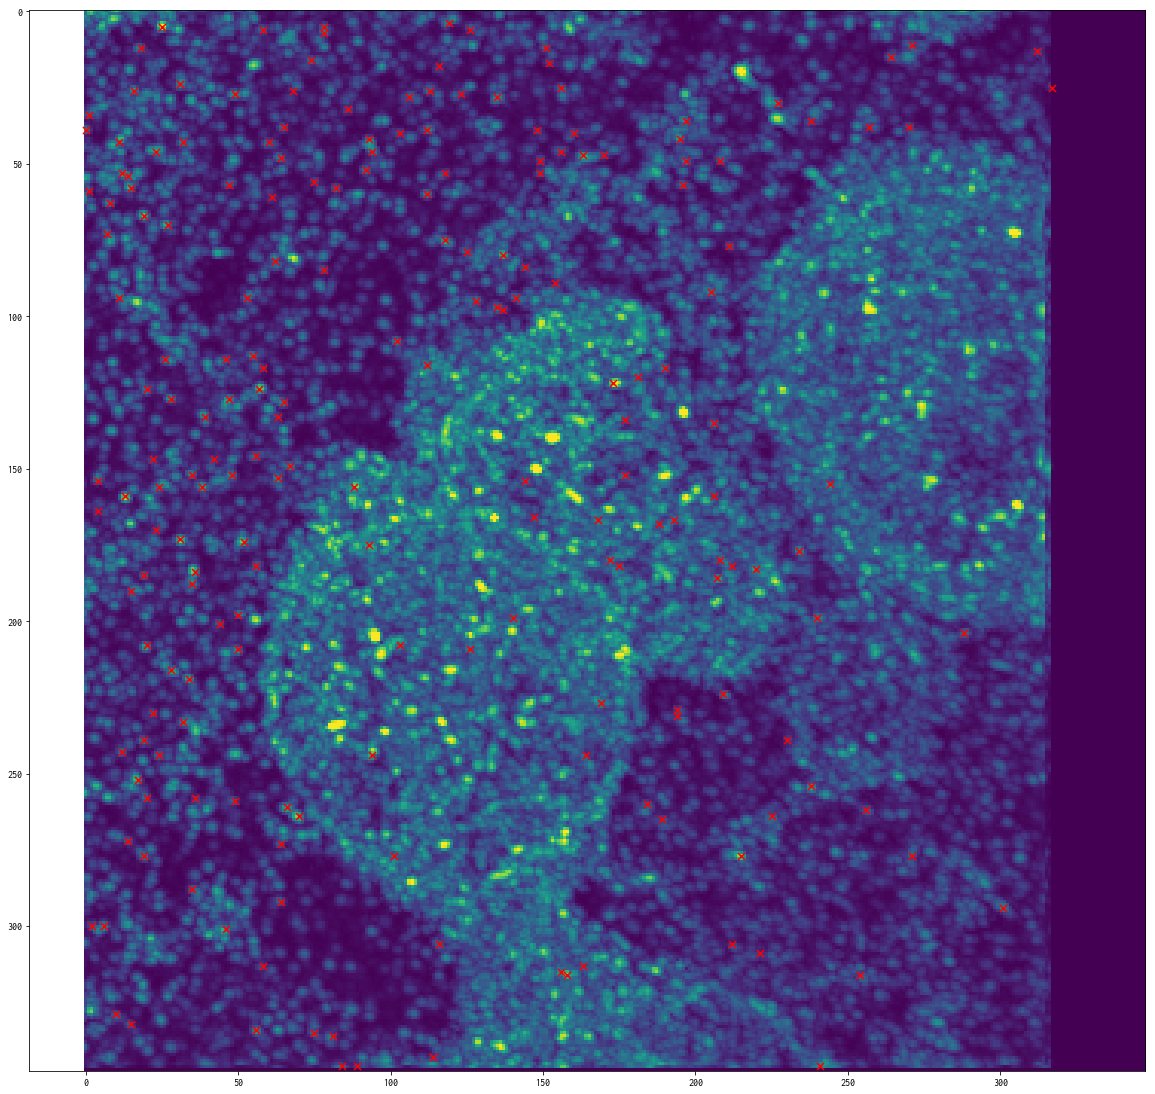

In [173]:
f, ax = plt.subplots(figsize=(20, 20))
plt.imshow(np.squeeze(maxproj.xarray.values), vmax=np.percentile(np.ravel(maxproj.xarray.values), 99.9))
plt.scatter(camk2a.x, camk2a.y, c="r", marker="x", s=50)

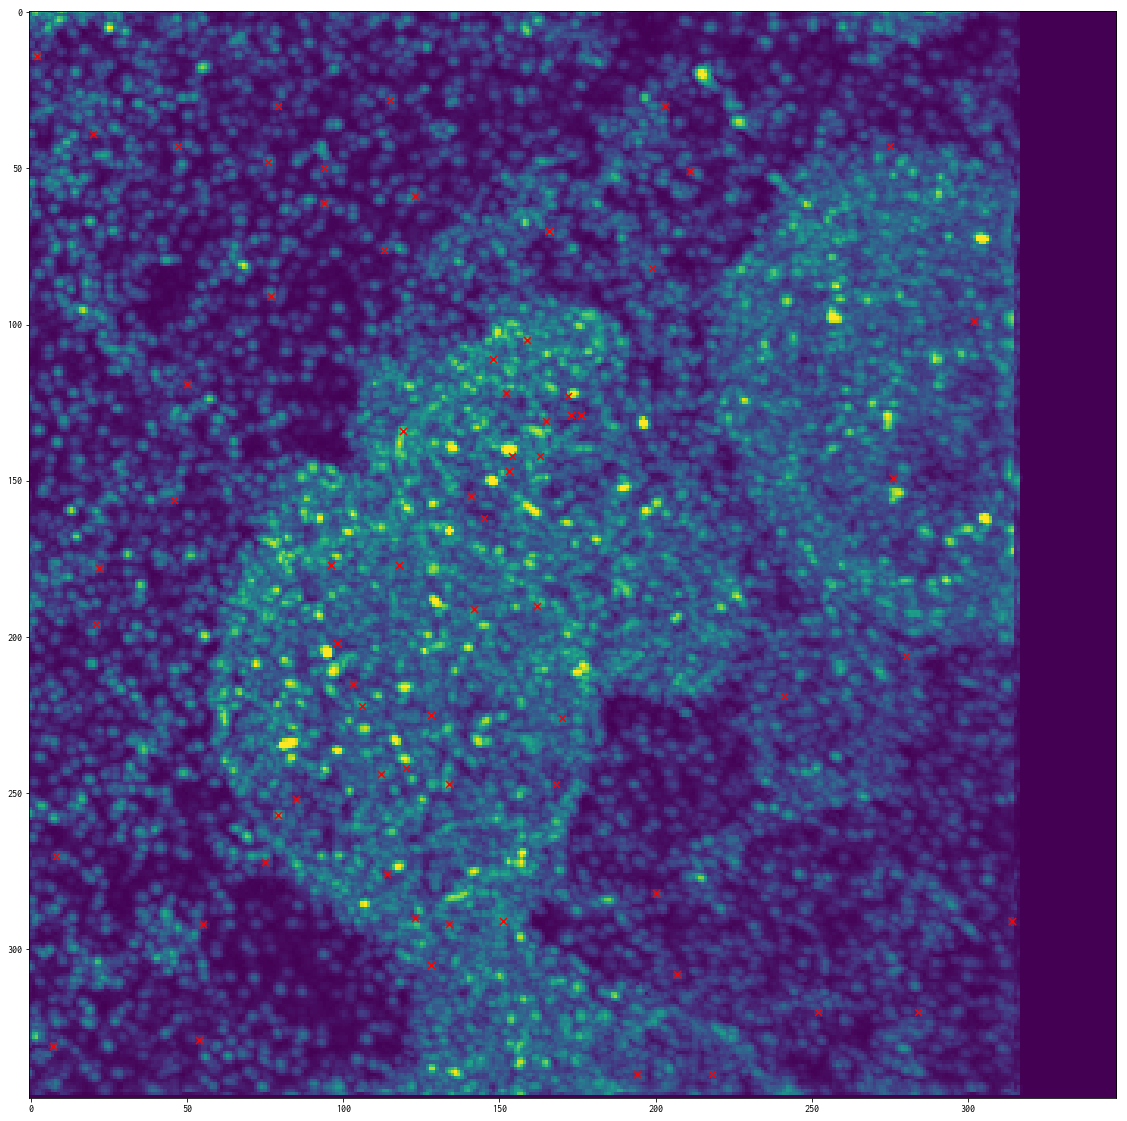

In [176]:
f, ax = plt.subplots(figsize=(20, 20))
plt.imshow(np.squeeze(maxproj.xarray.values), vmax=np.percentile(np.ravel(maxproj.xarray.values), 99.9))
plt.scatter(Rbfox3.x, Rbfox3.y, c="r", marker="x", s=50)

In [179]:
# are the data registered?
image = fov.get_image("primary", x=slice(1700, 2048), y=slice(1700, 2048))

proj = image.max_proj(Axes.CH).sel({Axes.ZPLANE: 5})

learn_translation = starfish.image.LearnTransform.Translation(reference_stack=proj.sel({Axes.ROUND: 0}), axes=Axes.ROUND, upsampling=1000)
transforms_list = learn_translation.run(proj)

In [ ]:
# good enough

In [202]:
[t[2].translation for t in transforms_list.transforms]

[array([0., 0.]),
 array([-0.279,  0.081]),
 array([-0.325,  0.216]),
 array([-0.28 ,  0.252])]

In [204]:
wth = starfish.image.Filter.WhiteTophat(masking_radius=3)
background_corrected = wth.run(image, in_place=False)

mh = starfish.image.Filter.MatchHistograms(group_by={Axes.CH, Axes.ROUND})
scaled = mh.run(background_corrected)

blur = starfish.image.Filter.GaussianLowPass(sigma=1)
blurred = blur.run(scaled)

pd = starfish.spots.DetectPixels.PixelSpotDecoder(
    codebook=exp.codebook,
    metric="euclidean",
    norm_order=2, # the L_n norm is taken of each pixel vector and codeword before computing the distance. this is n
    distance_threshold=0.5176, # minimum distance between a pixel vector and a codeword for it to be called as a gene
    magnitude_threshold=1.77e-5, # discard any pixel vectors below this magnitude
    min_area=4, # do not call a 'spot' if it's area is below this threshold (measured in pixels)
    max_area=np.inf, # do not call a 'spot' if it's area is above this threshold (measured in pixels)
)
intensities, ccdr = pd.run(blurred)

100%|██████████| 2739/2739 [00:03<00:00, 823.43it/s]


In [212]:
decoded_image = starfish.ImageStack.from_numpy(ccdr.decoded_image[None, None, :])

/Users/ajc/projects/spacetx/starfish/starfish/core/imagestack/imagestack.py:321: UserWarning: ImageStack detected as int64. Converting to float32...
  warnings.warn(f"ImageStack detected as {array.dtype}. Converting to float32...")
/Users/ajc/projects/spacetx/starfish/.venv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float32
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 9/9 [00:00<00:00, 252.60it/s]


In [215]:
starfish.display(decoded_image)

In [214]:
starfish.display(image)

In [222]:
pixels_count = pd.Series(*np.unique(intensities.target, return_counts=True)[::-1])

## Do the data agree?

In [227]:
from scipy.stats import pearsonr

idx = pixels_count.index.intersection(gene_counts.index)
pearsonr(gene_counts[idx], pixels_count[idx])

(0.686461211881129, 9.49709079905011e-47)

## Do we detect decoding enrichment? 

In [236]:
potential_rna = intensity_table.shape[0]
decoded_rna = decoded.shape[0]

codebook_space = 12 ** 4
codebook_size = exp.codebook.shape[0]

expected_decoding_rate = codebook_size / codebook_space
observed_decoding_rate = decoded_rna / potential_rna

observed_decoding_rate / expected_decoding_rate

5.90621500324988

This is on-par with ISS